In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.table import Table, vstack
from astropy.io import ascii
from astropy.modeling import models, fitting, custom_model

# this is a little ugly, but works for now...
from elcoll_utils import *

This data was taken using the f/9 WFS using ``elcoll_gui`` to automate the process. 

<IPython.core.display.Javascript object>


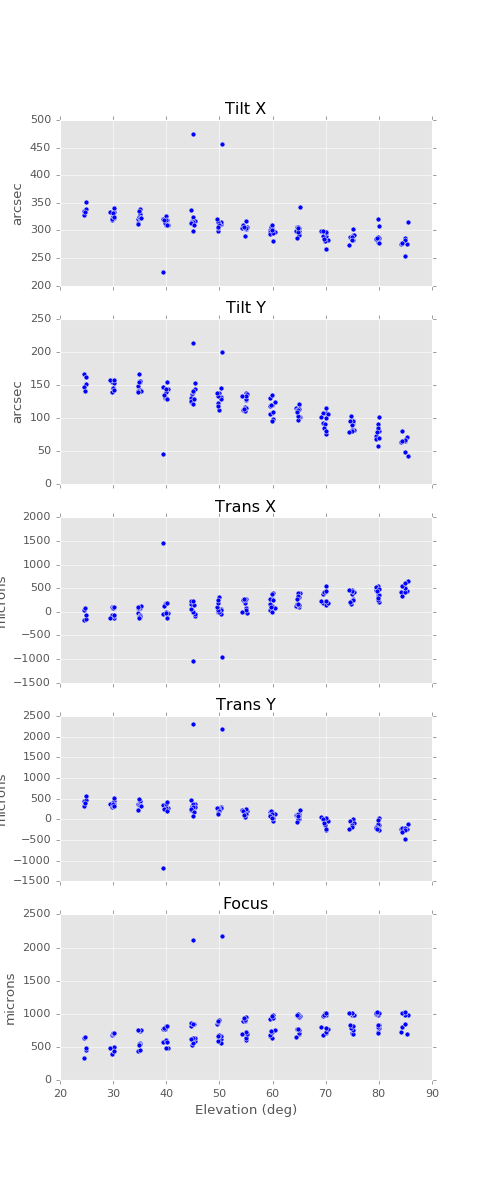

In [2]:
# only one data file for this night, though data was taken at multiple different times...
tot = elcoll_read("data/ELCOLL.20170109")
elcoll_plot(tot)

We have some spurious data points so we can ``show_in_notebook()`` to explore the data and remove them.  It turns out that the bad points are at index values 72, 73, and 74.  Probably due to a bad image that got analyzed and bogus corrections calculated and sent.

In [3]:
tot.show_in_notebook()

idx,el,tiltx,tilty,transx,transy,focus,temp,UT,oss1,oss2,oss3,oss4,oss5,oss6,oss
0,85.36421808,274.5,70.62,444.15,-233.64,697.87,13.0,01:19:02,14.4,{},14.1,{},12.9,{},13.8
1,79.93076012,279.54,84.52,345.41,-139.05,720.21,13.0,01:20:49,14.4,{},14.1,{},12.9,{},13.8
2,74.91933164,284.64,97.06,258.05,-52.13,713.39,12.75,01:22:33,14.2,{},14.0,{},12.9,{},13.7
3,70.14267156,289.53,107.98,183.54,24.97,713.68,12.75,01:24:18,14.2,{},13.9,{},12.8,{},13.6333333333
4,65.0089129,295.17,119.24,108.8,105.98,695.51,12.75,01:26:04,14.0,{},13.8,{},12.8,{},13.5333333333
5,59.57480048,301.11,129.84,41.0,183.62,670.95,12.5,01:27:50,13.9,{},13.7,{},12.7,{},13.4333333333
6,54.91323934,306.52,138.31,-11.11,247.83,655.88,12.5,01:29:34,13.7,{},13.7,{},12.7,{},13.3666666667
7,50.25233266,311.74,145.56,-53.66,304.72,625.82,12.5,01:31:18,13.7,{},13.6,{},12.7,{},13.3333333333
8,45.38502464,317.54,152.4,-91.01,360.59,588.87,12.5,01:32:32,13.7,{},13.6,{},12.7,{},13.3333333333
9,84.23689638,274.84,63.56,428.17,-245.95,718.91,12.5,01:37:54,13.6,{},13.3,{},12.6,{},13.1666666667


<IPython.core.display.Javascript object>


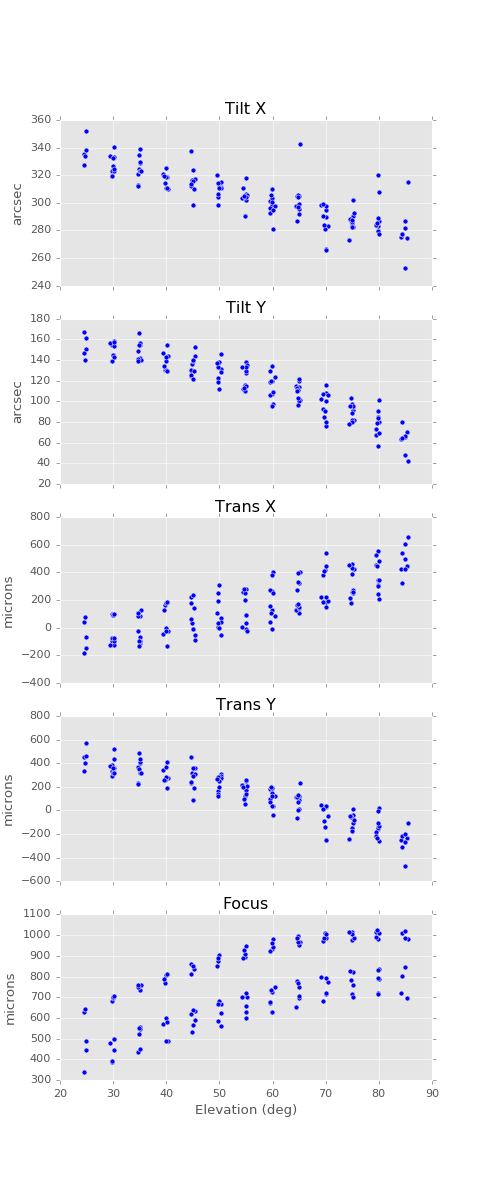

In [4]:
# make a new table and then trim the bad rows out
trim = tot.copy()
trim.remove_rows([72, 73, 74])
elcoll_plot(trim)

Set up ``astropy.modeling`` to use a basic Levenberg-Marquardt fitter. The ``elcoll_model`` is of the form:

Hexapod(el, $T_{oss}$) = $c_0$ sin(el) + $c_1$ cos(el) + $c_2$ $T_{oss}$ + $c_3$

In [5]:
fitter = fitting.LevMarLSQFitter()
elcoll = elcoll_model()
mods = {}

In [6]:
for k in keys:
    mods[k] = fitter(elcoll, x=trim['el'], y=trim['oss'], z=trim[k])

In [7]:
elcoll_results(mods)

Tilt X: -49.78*sin(el) +29.10*cos(el) -0.26*T_oss +331.76
Tilt Y: +31.34*sin(el) +130.56*cos(el) +6.46*T_oss -50.27
Trans X: -86.66*sin(el) -717.65*cos(el) -74.96*T_oss +1471.68
Trans Y: +138.06*sin(el) +907.18*cos(el) +32.40*T_oss -830.67
Focus: +800.06*sin(el) +30.21*cos(el) -113.29*T_oss +1385.54


<IPython.core.display.Javascript object>


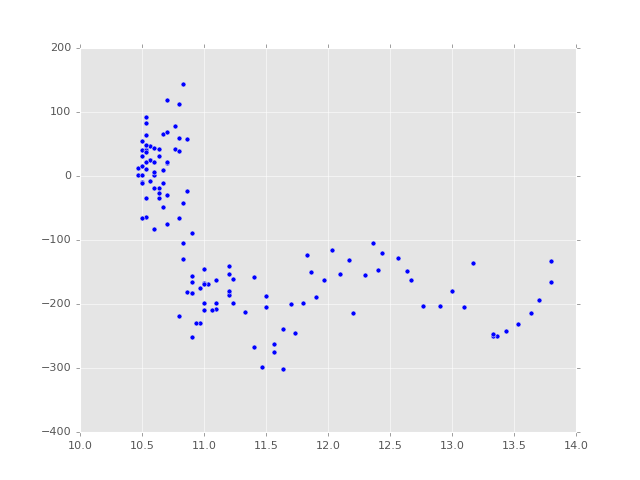

In [8]:
# take a look at residuals as a function of OSS temperature
#plt.scatter(trim['oss'], trim['transx'] - mods['transx'](trim['el'], trim['oss']))
plt.scatter(trim['oss'], trim['transx'] - mods['transx'](trim['el'], 10.0))
plt.show()

What looks like a temperature-dependent term to the fit is actually more of a temporal change.  The data taken later at a stable temp of ~10.7 C is all clustered around ~0, but the early data taken over a range of temperature clusters around ~-200. 

<IPython.core.display.Javascript object>


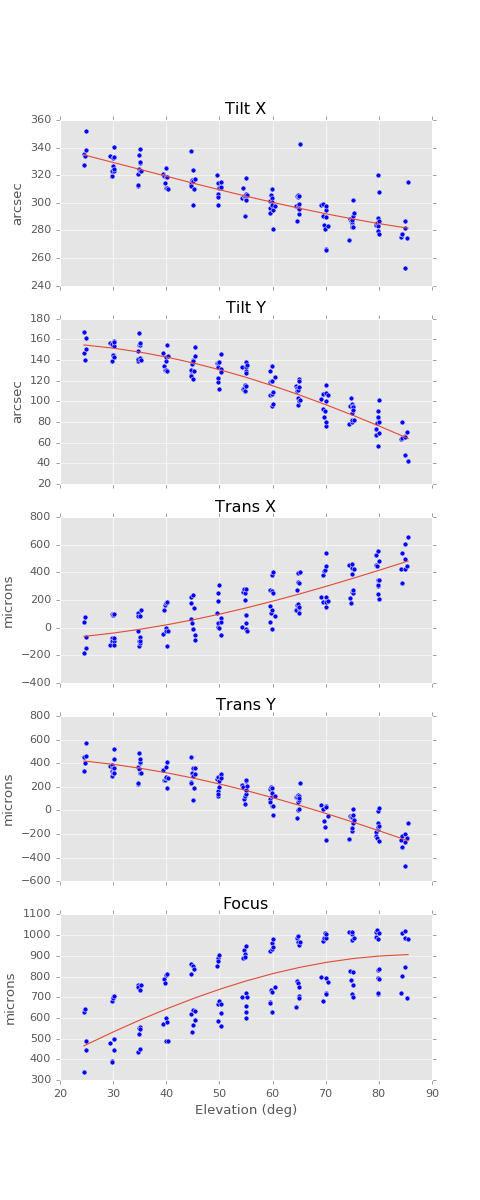

In [11]:
# plot the models with the data.  because data at the same elevation can be taken over a range of temperature, 
# we just plot the fits using the mean temperature. 
trim.sort('el')
elcoll_plot(trim, models=mods, mean_temp=True)  # this calculates the elcoll_model()'s at the mean temp for the data

In [16]:
# load the current elcoll parameters from settings.xml
current = load_current_models(hexapod='f9', inst='blue')

In [17]:
current

{'focus': <elcoll_model(c0=725.2, c1=81.3, c2=-46.7, c3=293.4)>,
 'tiltx': <elcoll_model(c0=-45.8, c1=48.3, c2=0.0, c3=78.5)>,
 'tilty': <elcoll_model(c0=56.6, c1=157.4, c2=0.0, c3=-83.33)>,
 'transx': <elcoll_model(c0=-628.2, c1=-1147.6, c2=0.0, c3=2097.8)>,
 'transy': <elcoll_model(c0=199.7, c1=1046.9, c2=0.0, c3=-919.7)>}

<IPython.core.display.Javascript object>


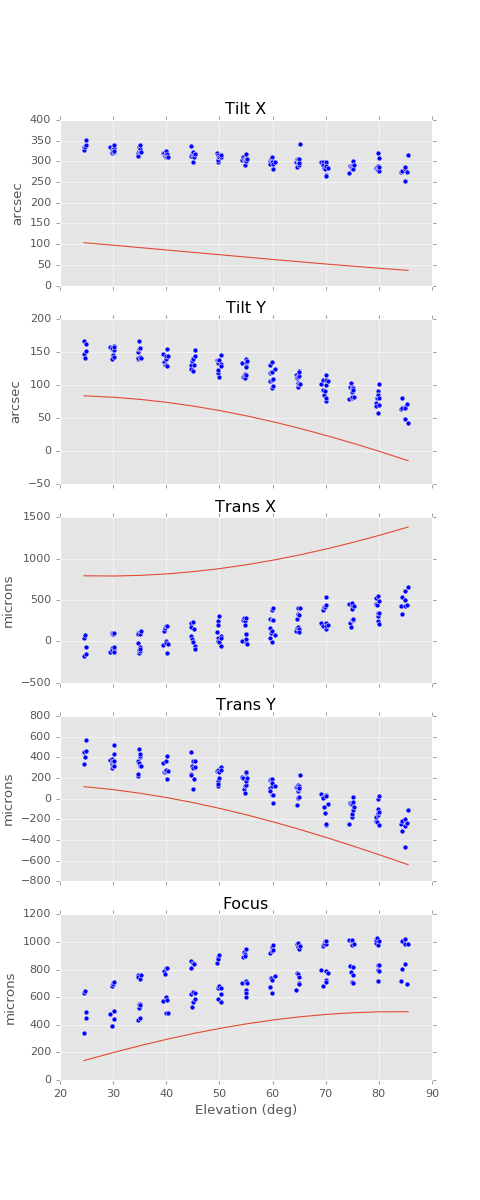

In [18]:
elcoll_plot(trim, models=current, mean_temp=True)

<IPython.core.display.Javascript object>


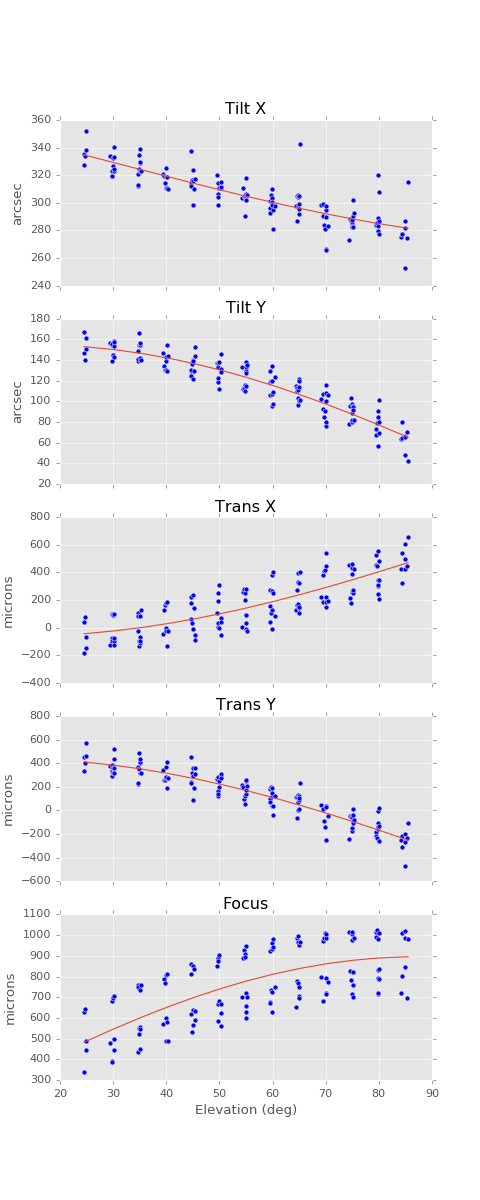

Tilt X: -49.94*sin(el) +29.11*cos(el) +0.00*T_oss +328.99
Tilt Y: +35.38*sin(el) +130.20*cos(el) +0.00*T_oss +19.72
Trans X: -133.46*sin(el) -713.37*cos(el) +0.00*T_oss +659.84
Trans Y: +158.29*sin(el) +905.33*cos(el) +0.00*T_oss -479.80
Focus: +758.49*sin(el) +34.01*cos(el) -46.70*T_oss +664.37


In [15]:
# re-fit with T_oss terms fixed to current values
fix_mods = {}
for k in keys:
    elcoll.c2.value = current[k].c2.value
    elcoll.c2.fixed = True
    fix_mods[k] = fitter(elcoll, x=trim['el'], y=trim['oss'], z=trim[k])
elcoll_plot(trim, models=fix_mods, mean_temp=True)
elcoll_results(fix_mods)

## Summary

In a relative sense, the F/9 elcoll model is working ok.  The trends with elevation line up well with what was observed given the scatter in the observations.  However, there are significant zeropoint offsets that the telescope operators have also noticed.

Letting the $T_{oss}$ dependent terms vary results in what appears to be spurious results.  There is a shift between the data taken earlier and later in the night, but other than with the focus term, it doesn't appear to be strictly due to $T_{oss}$.  

The fits derived using the existing $T_{oss}$ terms and letting the others vary look good so we'll want to update ``settings.xml`` with them.  